In [12]:

import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.custom_dm as cdm

from importlib import reload



In [80]:
256*16

4096

In [126]:
reload(cscoob)
reload(cdm)
model = cscoob.SCOOB(npix=200, oversample=10, npsf=200, dm_fill_factor=0.9)


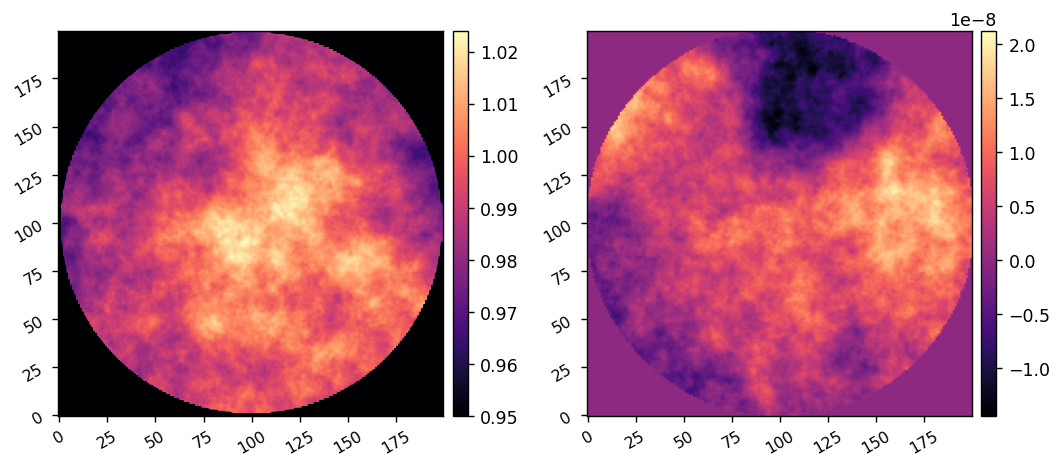

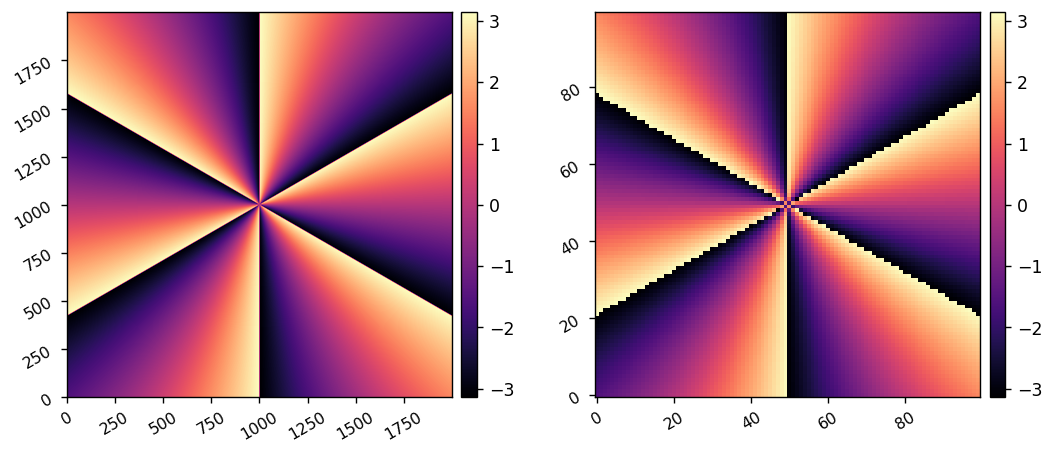

In [127]:
reload(cscoob)
WFE = cscoob.generate_wfe(diam=model.pupil_diam, distance=50*u.mm, 
                          amp_rms=0.025*u.nm, amp_index=3, amp_seed=1234,
                          opd_rms=10*u.nm, opd_index=3, opd_seed=2345,
                          npix=model.npix, oversample=model.oversample,)
model.WFE = WFE
imshow2(xp.abs(WFE), xp.angle(WFE)/(2*np.pi)*model.wavelength.to_value(u.m), 
        npix=model.npix,
        vmin1=0.95)

VC = cscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)
imshow2(xp.angle(VC), xp.angle(scoobpsf.utils.pad_or_crop(VC, 100)))

LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS

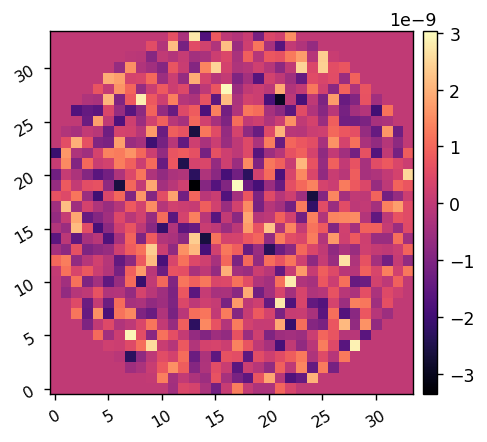

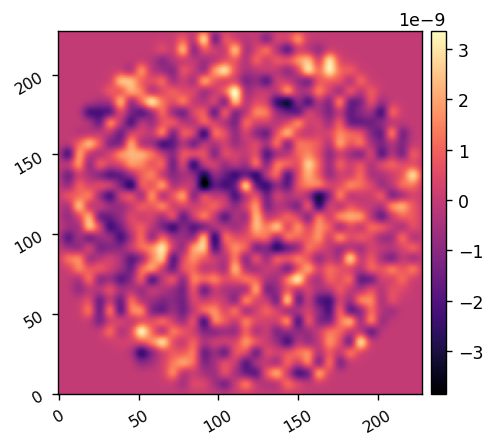

In [115]:
model.set_dm(np.random.randn(model.Nacts)*1e-9)
imshow1(model.get_dm())
imshow1(model.get_dm_surface())
model.reset_dm()

In [117]:
model.WFE = None
model.WFE = WFE

In [118]:
model.reset_dm()

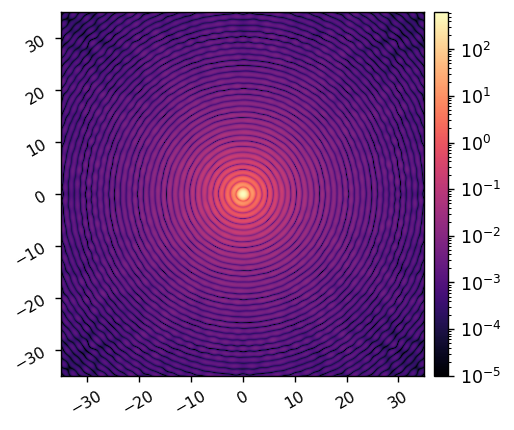

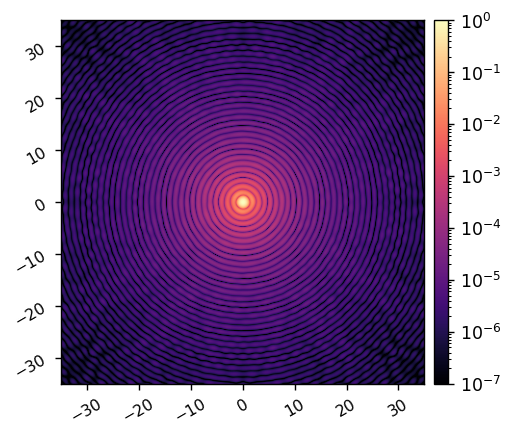

In [135]:
model.npsf = 350
model.FPM = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)
model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

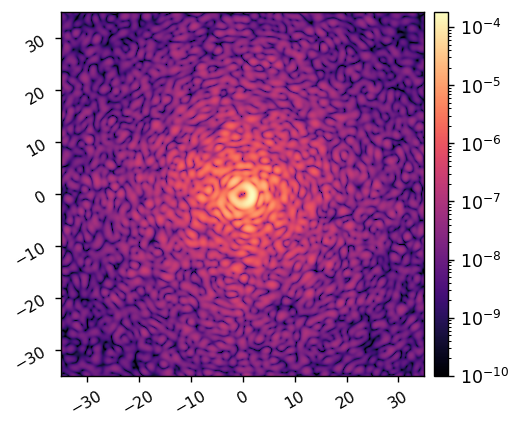

In [136]:
model.FPM = VC

image = model.snap(plot=True, vmin=1e-10)

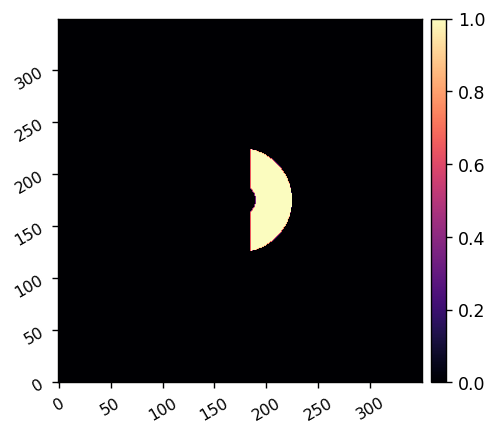

In [137]:
control_mask = (model.im_grid_pol[0] > 3)*(model.im_grid_pol[0] < 10)*(model.im_grid_car[0]>2)
imshow1(ensure_np_array(control_mask))

In [131]:
import time
def build_response(sysi, amp, 
                   control_mask,
                   plot=False,
                  ):
    start = time.time()
    dm_mask = sysi.dm_mask.flatten()
    
    ref_wf = sysi.propagate()
    
    Nacts = int(dm_mask.sum())
    Nmask = int(control_mask.sum())
    
    num_modes = sysi.Nact**2
    modes = np.eye(num_modes) # each column in this matrix represents a vectorized DM shape where one actuator has been poked
    
    responses = xp.zeros((2*Nmask, Nacts))
    count = 0
    print('Calculating Jacobian: ')
    for i in range(num_modes):
        if dm_mask[i]:
            mode = modes[i].reshape(sysi.Nact,sysi.Nact)

            sysi.add_dm(amp*mode)
            wavefront_pos = sysi.propagate()
            sysi.add_dm(-amp*mode)
            
            sysi.add_dm(-amp*mode)
            wavefront_neg = sysi.propagate()
            sysi.add_dm(amp*mode)
            
            response = (wavefront_pos - wavefront_neg) / 2/amp
            
            responses[::2,count] = response[control_mask].real
            responses[1::2,count] = response[control_mask].imag
            
            print('\tCalculated response for mode {:d}/{:d}. Elapsed time={:.3f} sec.'.format(count+1, Nacts, time.time()-start), end='')
            print("\r", end="")
            count += 1
        else:
            pass
    print()
    print('Jacobian built in {:.3f} sec'.format(time.time()-start))
    
    return responses

In [132]:
response_matrix = build_response(model, 1e-9, control_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=17.355 sec.
Jacobian built in 17.355 sec


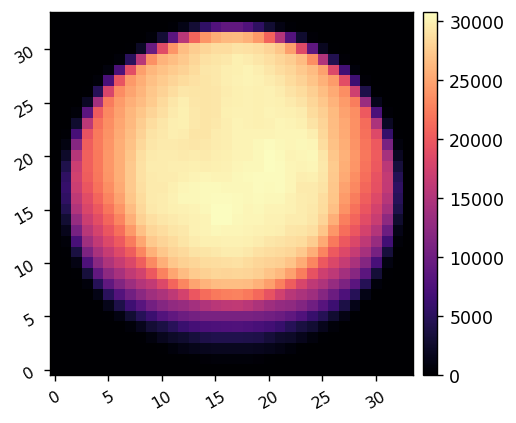

In [133]:
dm_response = xp.sqrt(xp.mean(xp.abs(response_matrix)**2, axis=0))
dm_response = model.DM.map_actuators_to_command(xp.asarray(dm_response))
imshow1(dm_response)